In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import talib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [19]:
IMAGES_PATH = Path("../images/")  
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [20]:
class DataPrep:
    
    def __init__(self,ticker,batch="train", source=Path('../data/assets.h5'), destination=Path('../data/data.h5')):
        self.source = source
        self.ticker = ticker
        self.path = 'yfinance/prices/{}/{}'.format(batch,ticker.lower())
        self.destination = destination
        self.dest_path = 'model_data/{}/{}'.format(ticker,batch)
        
    def extract_data(self):
        with pd.HDFStore(self.source) as store:
            data = (store[self.path]
                    .dropna()
                    .drop(['Close'], axis = 1))
        return data
    
    def _compute_bb(self,close):
        high, mid, low = BBANDS(close, timeperiod=20)
        return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)
    
    def _compute_atr(self,price_data):
        df = ATR(price_data.high, price_data.low, 
                 price_data.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    
    def _compute_macd(self,close):
        macd = MACD(close)[0]
        return (macd - np.mean(macd))/np.std(macd)
            
    def transform_data(self, frame=None):
        
            
            frame_tr = frame.rename(columns ={ "Open": "open",
                                                "High": "high",
                                                "Low" : "low",
                                               "Adj Close" : "close",
                                               "Volume" : "volume"})
            
            lags = [1, 5, 10, 21, 42, 63]
            periods = [5,21,63]
            
                # trends indicators
            
            for t in periods:
                frame_tr[f'SMA_{t}'] = talib.SMA(frame_tr.close, timeperiod = t)
                
             #lagged returns
            for lag in lags:
                frame_tr['return_{}d'.format(lag)] = np.log(frame_tr.close/frame_tr.close.shift(lag))
            
                #overlap studies
            
            frame_tr['HT_TRENDLINE'] = talib.HT_TRENDLINE(frame_tr.close)
            
            #Bollinger bands
            
            frame_tr = frame_tr.join(frame_tr.close.transform(self._compute_bb))
            frame_tr['BB_HIGH'] = frame_tr.bb_high.sub(frame_tr.close).div(frame_tr.bb_high).apply(np.log1p)
            frame_tr['BB_LOW'] = frame_tr.close.sub(frame_tr.bb_low).div(frame_tr.close).apply(np.log1p)
            
            
                #Momentum indicators 
            
            #RSI
            frame_tr['RSI'] = frame_tr.close.transform(RSI)
            
            
            #moving average convergence/divergence
            
            frame_tr['MACD'] = self._compute_macd(frame_tr.close)
            
            # Plus/minus directional index
            
            frame_tr['PLUS_DM'] = talib.PLUS_DM(frame_tr.high, frame_tr.low, timeperiod=10)
            frame_tr['MINUS_DM'] = talib.MINUS_DM(frame_tr.high, frame_tr.low,timeperiod=10)
            
            # Average directional movement index
            
            frame_tr['ADX'] = talib.ADX(frame_tr.high, frame_tr.low, frame_tr.close, timeperiod=14)
            
            
            # percentage price oscillator(PPO)
            frame_tr['PPO'] = talib.PPO(frame_tr.close, fastperiod = 12, slowperiod=26, matype=0)
            
            # stochastic oscillator
            
            slowk, slowd = talib.STOCH(frame_tr.high,
                           frame_tr.low,
                           frame_tr.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
            frame_tr['STOCH'] = slowd / slowk
            
            
            # Money flow index
            frame_tr['MFI'] = talib.MFI(frame_tr.high,frame_tr.low, frame_tr.close,
                                       frame_tr.volume, timeperiod =14)
            
                #volume indicators
            
            #chaikin A/D line
            
            frame_tr['AD'] = talib.AD(frame_tr.high,
                       frame_tr.low,
                       frame_tr.close,
                       frame_tr.volume)
            
                #volatility indicators
                
            # average true range
            
            frame_tr['ATR'] = self._compute_atr(frame_tr)
            
           
            #forward returns
            
            for t in [1]:
                frame_tr[f'target_{t}d'] = frame_tr[f'return_{t}d'].shift(-t)
                   
        
            frame_tr.dropna(inplace = True)
            
            frame_tr.to_hdf(self.destination, self.dest_path )
            
            print("transformed {} can be found in {} under {}".format(self.ticker, self.destination, self.dest_path))
            
            return frame_tr
        
    def extract_transform(self):
        
        e = self.extract_data()
        return self.transform_data(e)
    

In [21]:
source = Path("../data/assets.h5")

In [26]:
ticker = 'aapl'

In [27]:
p = DataPrep(ticker,batch='train')

In [28]:
train = p.extract_transform()

transformed aapl can be found in ../data/data.h5 under model_data/aapl/train


In [29]:
test = DataPrep(ticker, batch="test")
test = test.extract_transform()

transformed aapl can be found in ../data/data.h5 under model_data/aapl/test


In [22]:
ohlcv = ['open', 'high', 'low', 'close', 'volume']

In [23]:
f = train.drop(ohlcv, axis = 1)

In [24]:
corr_mat = f.drop('target_1d', axis =1).corr(method='spearman')

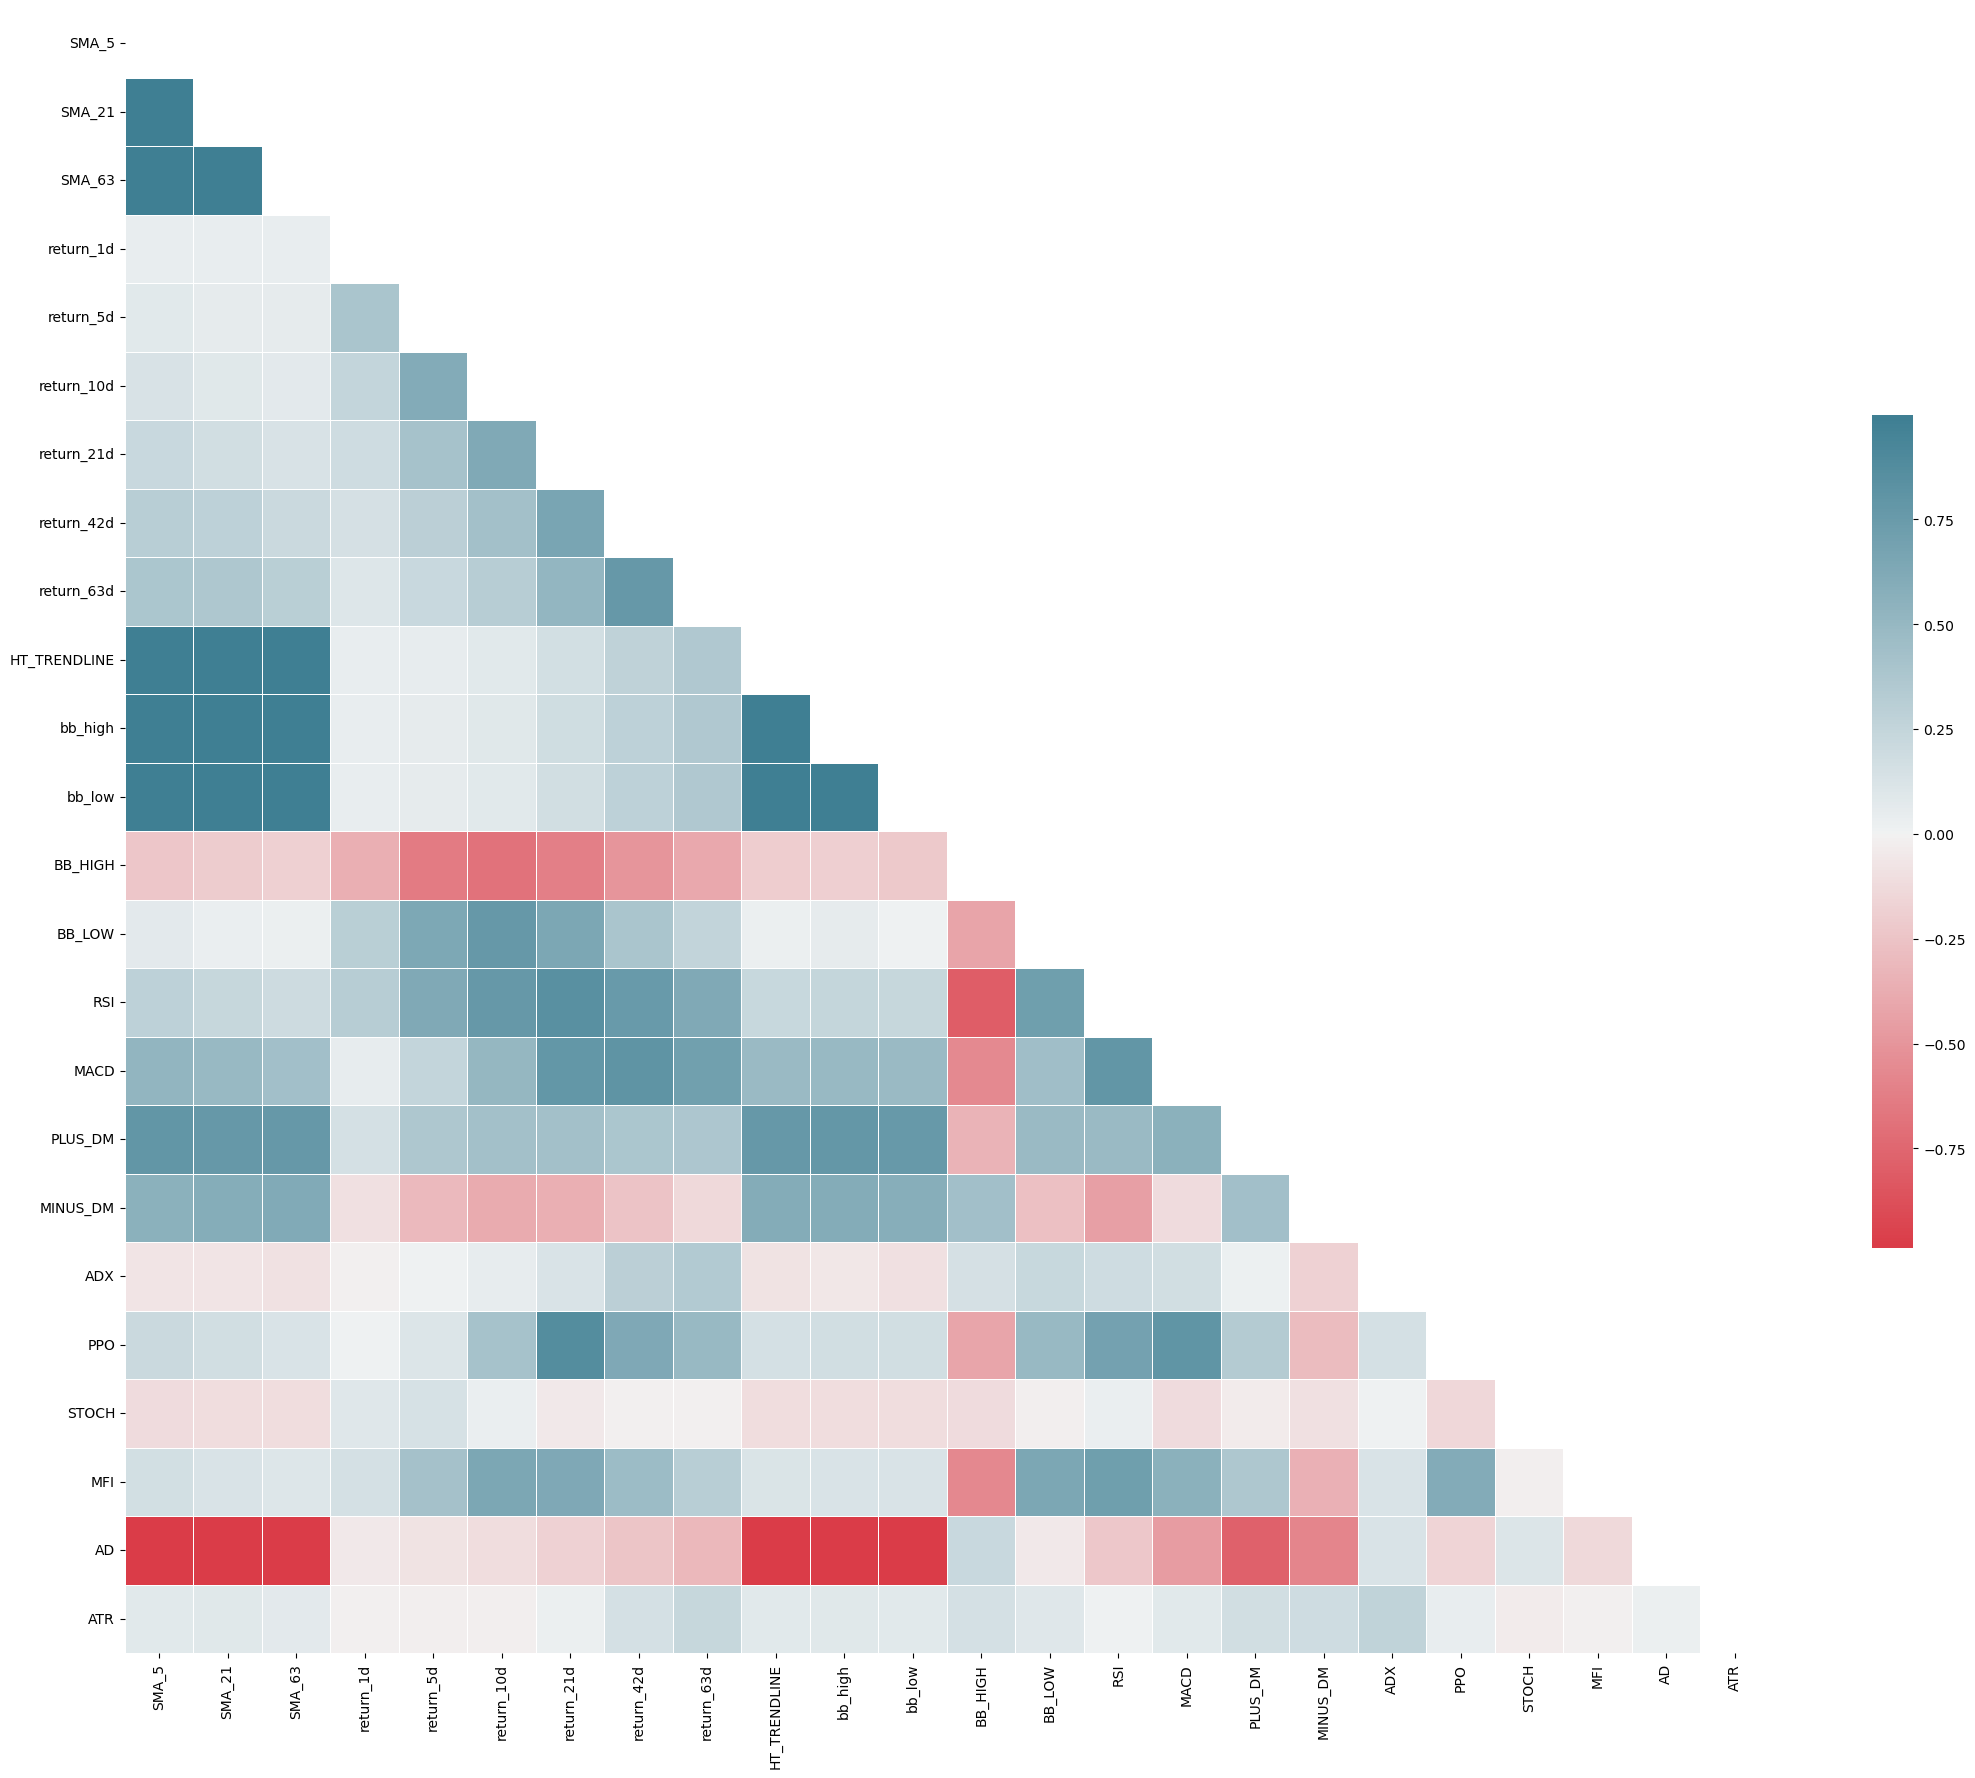

In [25]:
fig, ax = plt.subplots(figsize=(22, 18))
mask = np.triu(np.ones_like(corr_mat,dtype=bool))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr_mat,mask=mask, cmap=cmap, center = 0, square=True,
           linewidths = .5, cbar_kws={"shrink" : .5})
fig.tight_layout()
save_fig("correlation_features")

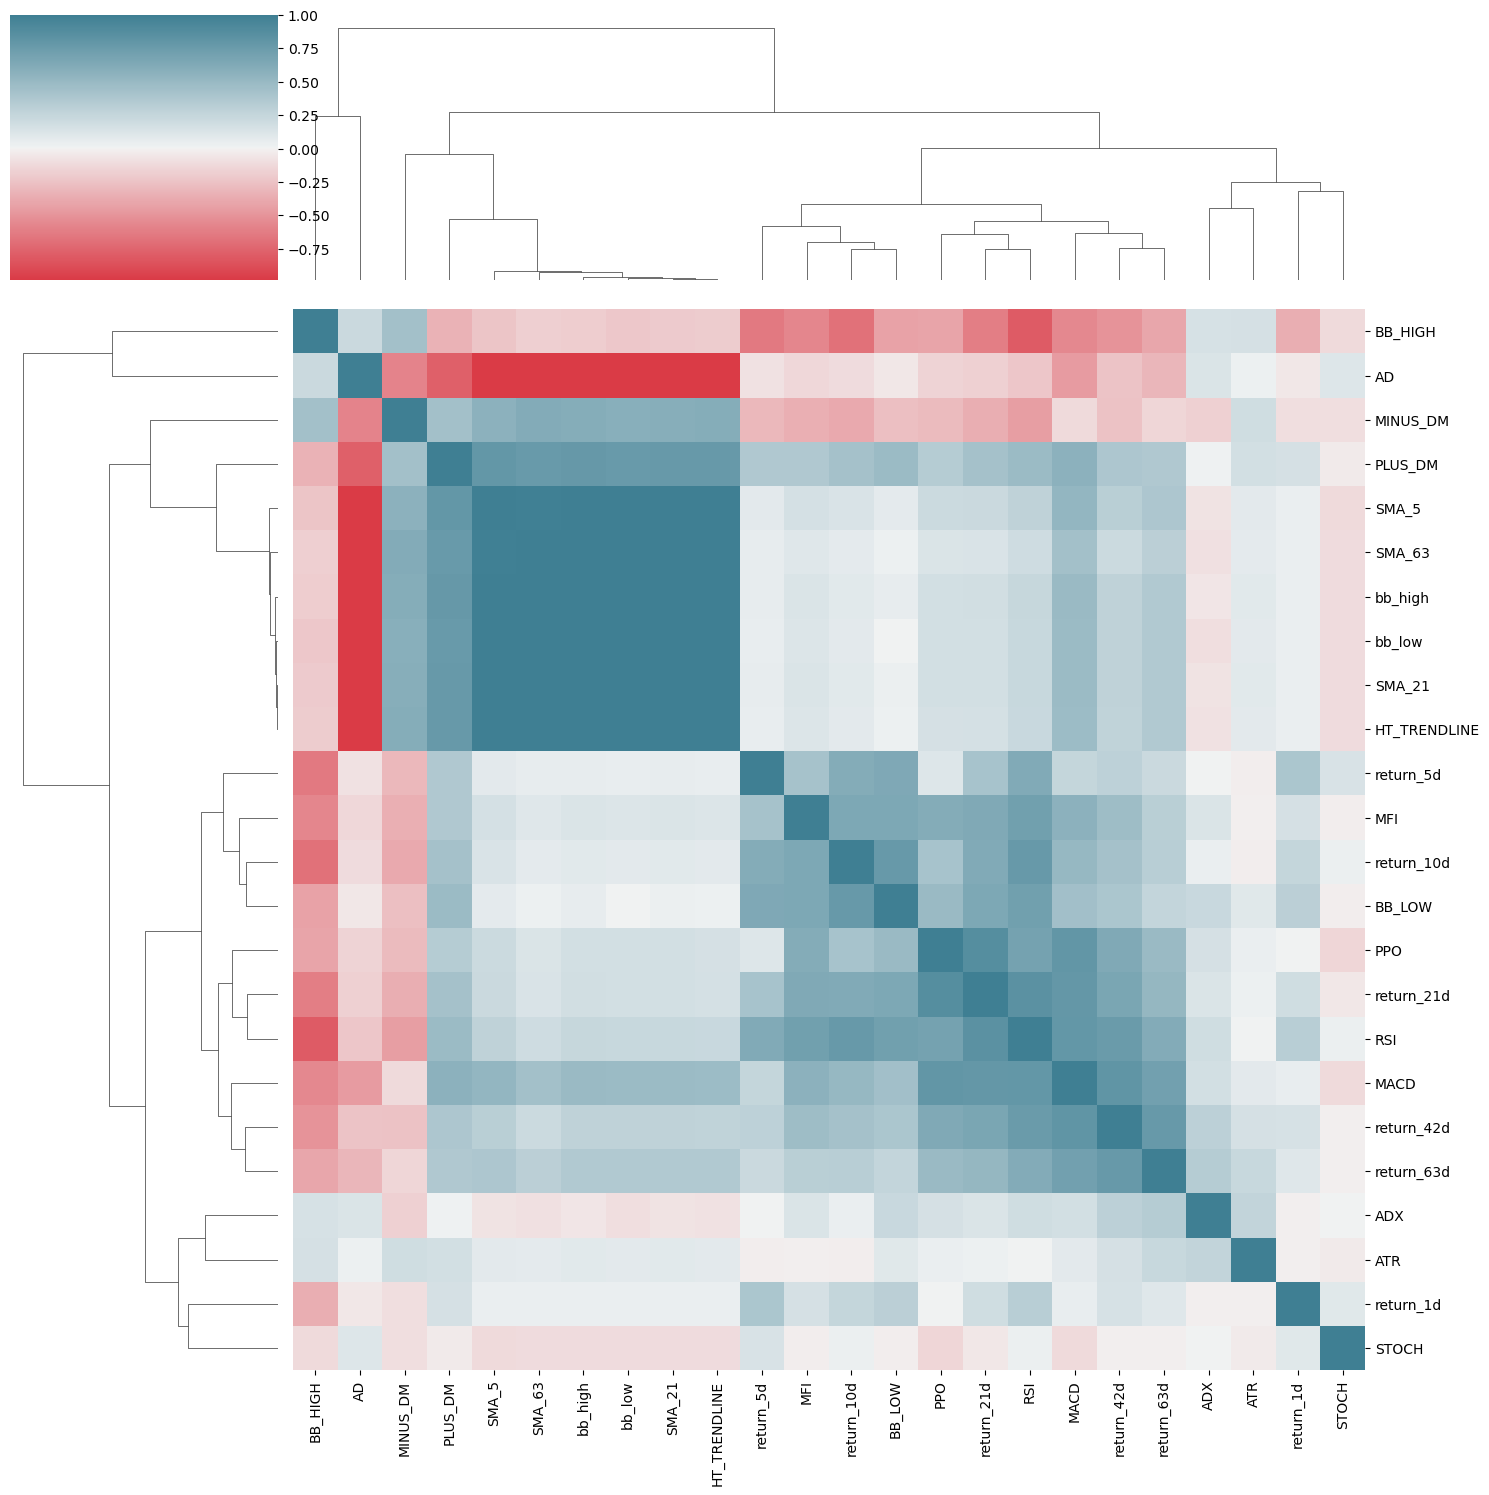

In [26]:
g = sns.clustermap(corr_mat, cmap=cmap, figsize=(15, 15))
save_fig("clustermap_features")

## Forward return correlation

In [27]:
fwd_corr = f.drop(['target_1d'], axis = 1).corrwith(f.target_1d, method='spearman')

In [28]:
fwd_corr = fwd_corr.dropna()

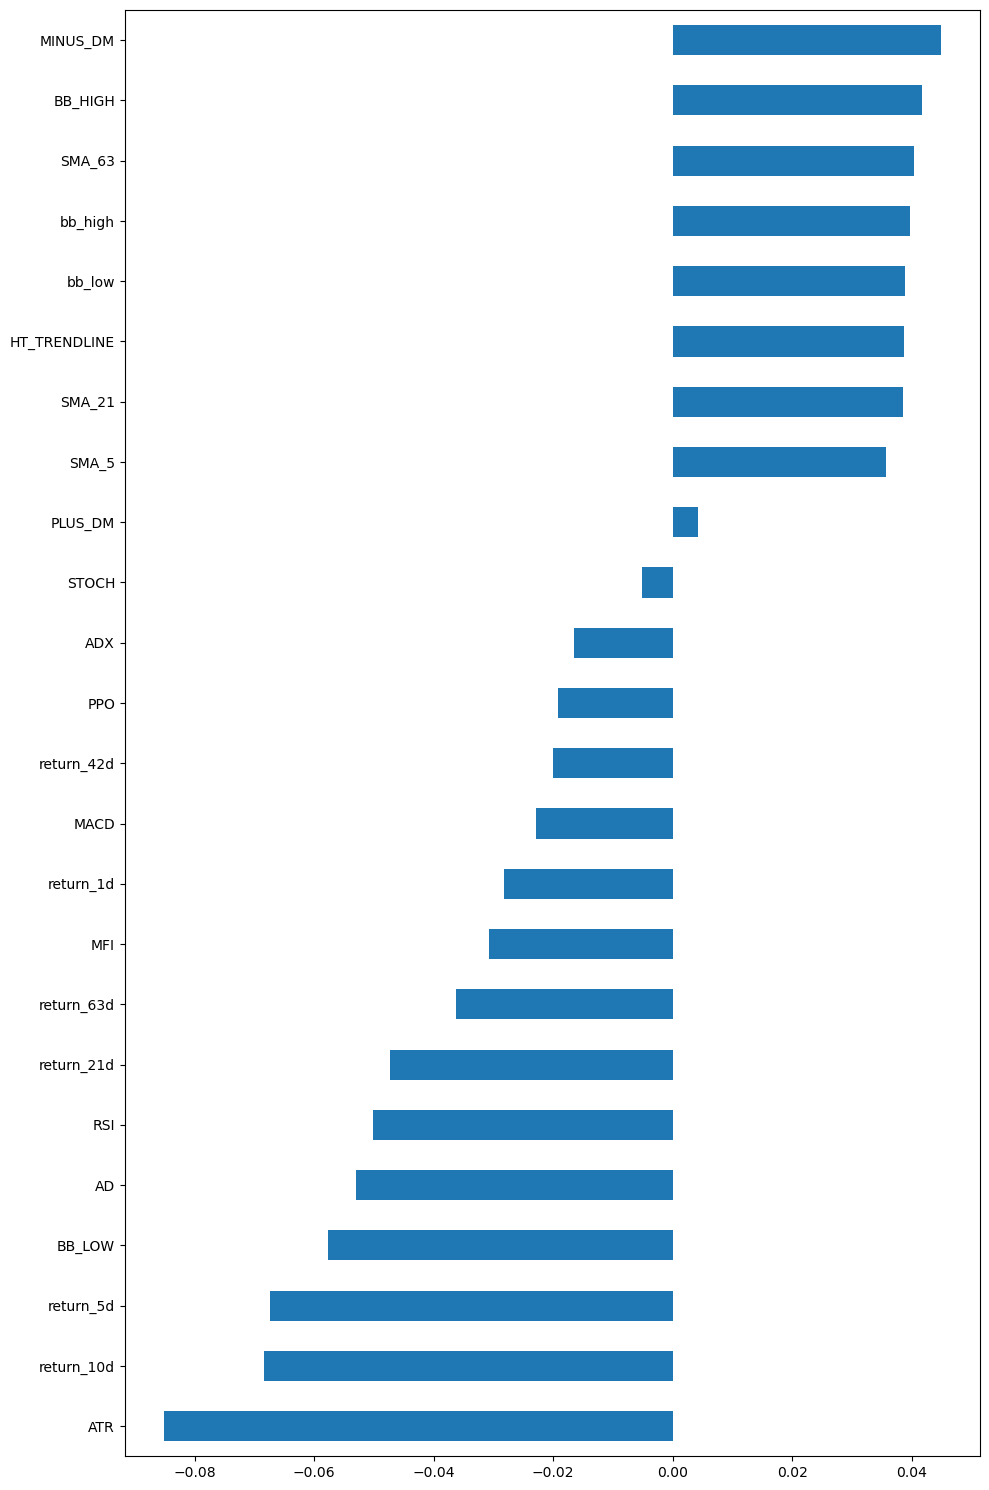

In [29]:
fwd_corr.sort_values().plot.barh(figsize=(10,15), legend = False)
save_fig("corr_features_target")

## Data Exploration

### RSI

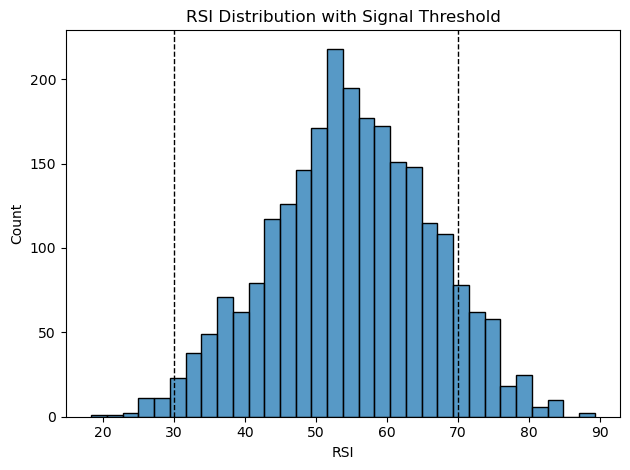

In [23]:
ax = sns.histplot(f.RSI.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()
save_fig("RSI_distribution_{}".format(ticker))

### Distribution of bollinger bands

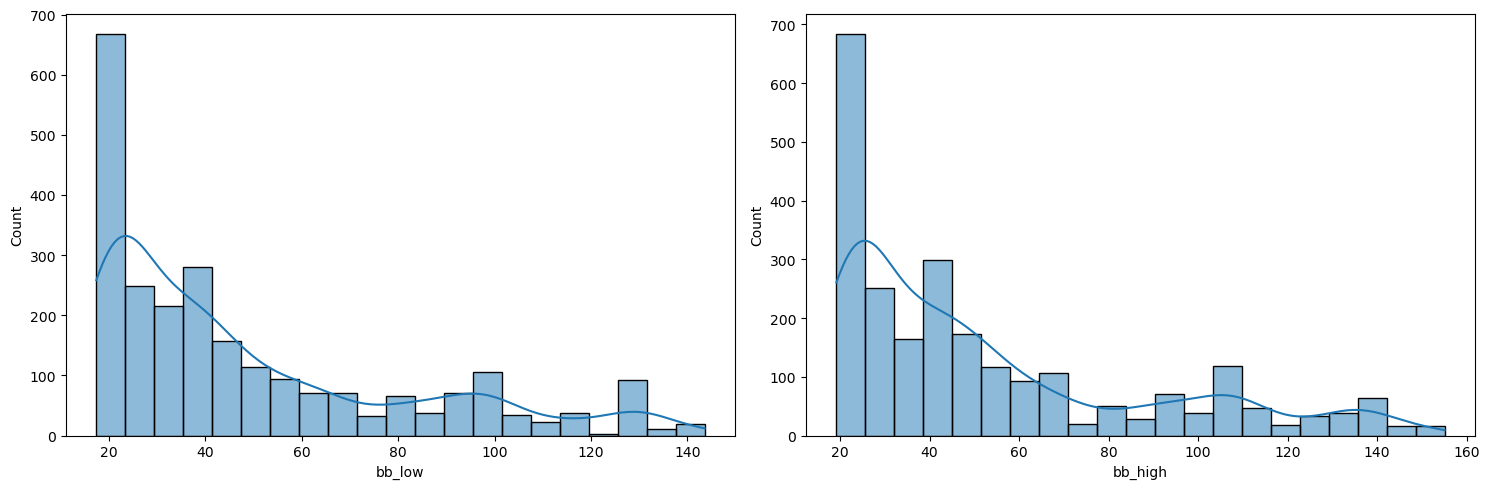

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(f.loc[:, 'bb_low'].dropna(), ax=axes[0], kde=True)
sns.histplot(f.loc[:, 'bb_high'].dropna(), ax=axes[1], kde=True)
plt.tight_layout()
save_fig("bb_bands_{}".format(ticker))

### distribution of  Average True Range

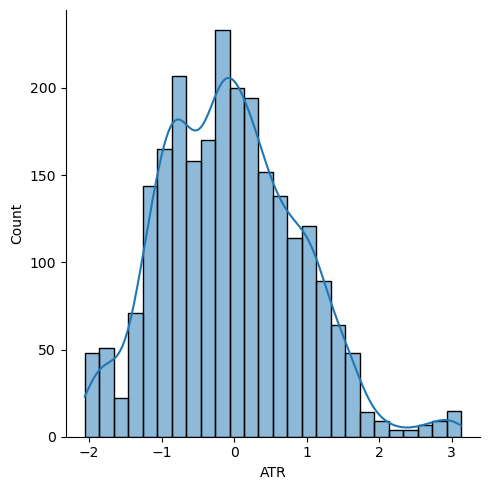

In [25]:
sns.displot(f.ATR.dropna(),kde=True)
plt.tight_layout()
save_fig("atr_{}".format(ticker))

### Moving Average Convergence/Divergence

In [26]:
f.MACD.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,451.0
mean         0.0
std          1.0
min         -3.5
0.1%        -3.4
1%          -2.1
2%          -1.7
3%          -1.5
4%          -1.4
5%          -1.3
50%         -0.2
95%          2.1
96%          2.3
97%          2.5
98%          2.6
99%          3.1
99.9%        3.8
max          4.2
Name: MACD, dtype: object

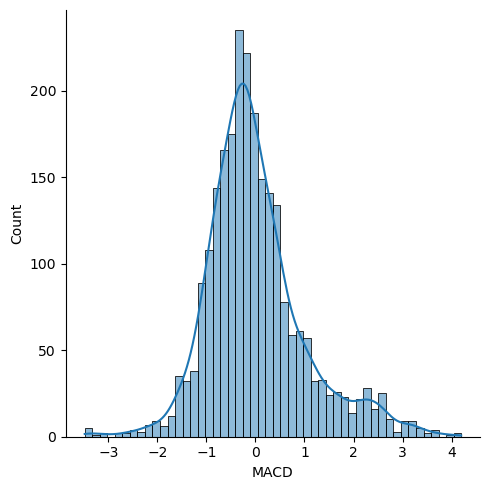

In [27]:
sns.displot(f.MACD.dropna(), kde=True)
plt.tight_layout()
save_fig('macd_{}'.format(ticker))

### lagged returns

In [28]:
lags = [1, 5, 10, 21, 42, 63]

In [35]:
returns = train.close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,1.44%
min,-11.40%
0.01%,-10.87%
0.1%,-6.50%
1%,-3.80%
50%,0.06%
99%,3.87%
99.9%,7.44%
99.99%,10.36%
max,10.45%


In [36]:
f.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2451 entries, 2010-04-06 to 2019-12-27
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SMA_5         2451 non-null   float64
 1   SMA_21        2451 non-null   float64
 2   SMA_63        2451 non-null   float64
 3   return_1d     2451 non-null   float64
 4   return_5d     2451 non-null   float64
 5   return_10d    2451 non-null   float64
 6   return_21d    2451 non-null   float64
 7   return_42d    2451 non-null   float64
 8   return_63d    2451 non-null   float64
 9   HT_TRENDLINE  2451 non-null   float64
 10  bb_high       2451 non-null   float64
 11  bb_low        2451 non-null   float64
 12  BB_HIGH       2451 non-null   float64
 13  BB_LOW        2451 non-null   float64
 14  RSI           2451 non-null   float64
 15  MACD          2451 non-null   float64
 16  PLUS_DM       2451 non-null   float64
 17  MINUS_DM      2451 non-null   float64
 18  ADX       